# Opponent Modelling in Heads Up Limit Hold'em

### Zachary Dawson

### TA: Prabal Malviya

# Problem DescriptionZachary Dawson


Limit Texas Hold'em is a game of imperfect information. In any game the hole cards of each player are hidden and, so you must predict how your opponent will act in various situations. This requires predictions of actions given certain hand attributes. Each action can be classified as either a fold, call, or raise. Hold'em is an interesting game with many nuances that are not understood by the general public. 

The original idea for a project creating an opponent model for poker came from [AlphaGo](https://storage.googleapis.com/deepmind-media/alphago/AlphaGoNaturePaper.pdf), a perfect information game. They started their training process by training a supervised maching using match histories of high amateur players. They then improved upon there inital predictions using partial solving and Monte Carlo Tree Search to create their final agent. Extending this to an imperfect information game would require a similar process.

Opponent modelling has been done many times before in poker. In [Learning Strategies for
Opponent Modeling in Poker](https://github.com/zachwdawson/DS4400FinalProject/blob/main/7132-30507-1-PB.pdf) supervised learning models were trained successfully to predict specific players actions given hand histories from that players games. There were also two books [1](https://github.com/zachwdawson/DS4400FinalProject/blob/main/2006_Book_ComputersAndGames.pdf) [2](https://github.com/zachwdawson/DS4400FinalProject/blob/main/poker%20metrics%20calculation.pdf) that went through various metrics and techniques for making creating poker AI. Many of the metrics used for features are calculated using algorithms from these works.

# Dataset

Raw hand histories from Poker Academy Pro are the raw data used for this project. A single hand in this form looks something like this:

******************************
    Poker Academy Pro #22,679
    Limit Texas Holdem ($1/$2)
    Table SimpleBot Logger
    November 24, 2010 - 13:23:10 (GMT)

     1} David               (sitting out)
     5) LoggingSimpleBot       $996  5c 5d
     6) SimpleBot *          $1,004  4s Ts

    SimpleBot posts small blind $0.50
    LoggingSimpleBot posts big blind $1
    SimpleBot calls $0.50 
    LoggingSimpleBot checks

    FLOP:  Th 4c 6h
    LoggingSimpleBot checks
    SimpleBot bets $1
    LoggingSimpleBot calls $1 

    TURN:  Th 4c 6h 5s
    LoggingSimpleBot bets $2
    SimpleBot raises $2
    LoggingSimpleBot raises $2
    SimpleBot raises $2
    LoggingSimpleBot calls $2 

    RIVER:  Th 4c 6h 5s Jc
    LoggingSimpleBot bets $2
    SimpleBot raises $2
    LoggingSimpleBot raises $2
    SimpleBot raises $2
    LoggingSimpleBot calls $2 
    SimpleBot shows 4s Ts
    LoggingSimpleBot shows 5c 5d

    LoggingSimpleBot wins $36 with Three of a Kind, Fives

******************************

These histories give all the necessary information to extract any feature, as all of the information is available, even the opponents hole cards. In an attempt to emulate previous work, The following features were meant to be extracted:

<img src="https://github.com/zachwdawson/DS4400FinalProject/blob/62f9f4106928f61cda531c731df64dffea6606dd/Screen%20Shot%202021-03-04%20at%2012.50.31%20PM.png?raw=true" alt="drawing" width="300"/>

Unfortunately, many of these features could not be extracted as they were too computationally expensive. PPOT and NPOT required iterating over all possible runouts of ocmmunal cards and calculate if you win or your opponent. It must also iterate over all opponent possible hands, which ends up being extraordinarily large, so these features could not be extraacted. As such, winning probability is a much simpler approximation than the formula layed out by Billings, which used both PPOT and NPOT in the calculation. Hand strength and rank are determined using [eval7](https://github.com/julianandrews/pyeval7), a python hand evaluator, which quickly determines how strong your hand is relative to all other hands. All other features are made simply by saving the previous actions from the hand and determining raise amounts and stack committed for your opponent and yourself. All feature extraction was run using python scripts that dumped into a csv that can be seen below.

In [1]:
import pandas as pd
import numpy as np

columns = ['action number','target', 'stage', 'dealer', 'hand_strength', 'hand_rank', 'opp_last_action',
        'my_last_action', 'my_stack_committed_curr_phase', 'opp_stack_committed_curr_phase',
        'my_num_raises_curr_phase', 'opp_num_raises_curr_phase',
        'my_num_raises_total', 'opp_num_raises_total','num_outs', 
        'winning_prob','highest_card', 'num_aces', 'num_kings', 'num_queens']
hands = pd.read_csv('/Users/zacharydawson/artificial-intelligence/poker/data/hand_histories/test.csv', names=columns)
hands = hands.drop(0, axis=0)
hands = hands.fillna(0)
np.max(hands['winning_prob'].astype(float))
hands['target'].astype(int).unique()
hands.astype({'action number': 'float', 'target': 'int32','stage': 'int32','dealer': 'bool','hand_strength': 'float','hand_rank': 'object',
             'opp_last_action': 'int32','my_last_action': 'int32','my_stack_committed_curr_phase': 'float','opp_stack_committed_curr_phase': 'float',
              'my_num_raises_curr_phase': 'float','opp_num_raises_curr_phase': 'float', 'my_num_raises_total': 'float',
             'opp_num_raises_total': 'float', 'num_outs': 'int32', 'winning_prob': 'float','highest_card': 'int32',
             'num_aces': 'int32','num_kings': 'int32','num_queens': 'int32'}).dtypes
hands['action number'] = hands['action number'].astype(int)
hands['dealer'] = hands['dealer'] * 1
hands = hands[(hands.target == 2)| (hands.target == 3) | (hands.target == 4) | (hands.target == 5) | (hands.target == 6)] ## remove all actions that are not check, call, bet, or fold: (all non-mandatory actions) 

hand_ranks={
    'High Card':0,
    'Pair':1,
    'Two Pair':2,
    'Trips':3,
    'Straight':4,
    'Flush': 5,
    'Full House': 6,
    'Quads': 7,
    'Straight Flush': 8
}

hands['hand_rank'] = hands['hand_rank'].map(hand_ranks)
hands['hand_rank'] = hands['hand_rank'].astype(int)
hands['winning_prob'] = hands['winning_prob'] / 100

hands.head(10)

/Users/zacharydawson/artificial-intelligence/poker/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,action number,target,stage,dealer,hand_strength,hand_rank,opp_last_action,my_last_action,my_stack_committed_curr_phase,opp_stack_committed_curr_phase,my_num_raises_curr_phase,opp_num_raises_curr_phase,my_num_raises_total,opp_num_raises_total,num_outs,winning_prob,highest_card,num_aces,num_kings,num_queens
32768,11,2,3,0,0.005564,0,3.0,4.0,0.0,2.0,0.0,2.0,5.0,8.0,18,0.378,11.0,0,0,0
32771,2,6,0,1,0.004551,0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0,0.5148,0,0,0,0
32772,3,5,0,0,0.006129,0,1.0,6.0,1.0,1.5,1.0,2.0,1.0,2.0,0,0.64005,0,0,0,0
32773,4,4,1,0,0.130402,1,5.0,6.0,0.0,0.0,0.0,0.0,2.0,2.0,8,0.168,12.0,0,0,0
32774,5,2,1,1,0.00611,0,6.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,12,0.252,12.0,0,0,0
32777,2,2,0,0,0.002033,0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0,0.40155,0,0,0,0
32780,2,6,0,1,0.00355,0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0,0.4652,0,0,0,0
32781,3,2,0,0,0.00537,0,1.0,6.0,1.0,1.5,1.0,2.0,1.0,2.0,0,0.5383,0,0,0,0
32784,2,2,0,1,0.003034,0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0,0.43395,0,0,0,0
32787,2,6,0,1,0.001517,0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0,0.3855,0,0,0,0


In [2]:
target = hands['target']
options = {
    2: 0,
    3: 1,
    5: 1,
    4: 2,
    6: 2
}
target_scaled = target.map(options).astype(int)

In [3]:
features = hands.drop(['action number', 'target'], axis=1)
features.head(5)
features['hand_rank'].unique()

array([0, 1, 3, 5, 2, 4, 7, 6, 8])

## Final DataFrame

The final dataset includes 18 features that include the stage (preflop, postflop, turn, or river), whether or not the player is the dealer, the hand strength of the players hole cards and the communal cards, hand_rank (High Card, Pair, Two Pair, Trips, Straight, Flush, Full House, Quads, Straight Flush), opp_last_action(fold, call, check, bet, raise), my_last_action, stack sizes committed by each player, number of raises by each player, number of outs to a better hand, the probability the player wins the hand, and some statistics about the board cards.

## Charts

In [4]:
## Prepare data for charts

import plotly.express as px
chart_df = features.copy()
chart_df['target'] = target_scaled
chart_df.groupby(['stage', 'dealer']).count()['hand_strength']

action = {}

for stage in chart_df['stage'].unique():
    dealer_action = {}
    for dealer in [0,1]:
        stage_action = {}
        for target in chart_df['target'].unique():
            stage_action[target] = chart_df[(chart_df['stage'] == stage) & (chart_df['target'] == target) & (chart_df['dealer'] == dealer)].count()['hand_strength']
        dealer_action[dealer] = stage_action 
        
    action[stage] = dealer_action

stage_hand_rank = {}
for stage in chart_df['stage'].unique():
    hand_rank_action = {}
    for hand_rank in chart_df['hand_rank'].unique():
        hand_rank_action[hand_rank] = chart_df[(chart_df['stage'] == stage) & (chart_df['hand_rank'] == hand_rank)].count()['hand_strength']
    
    stage_hand_rank[stage] = hand_rank_action

    

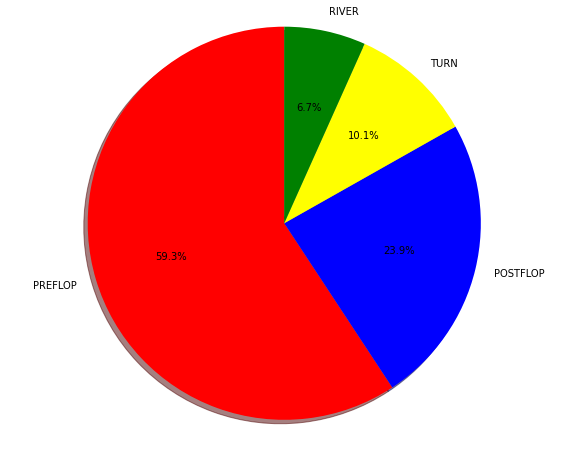

In [5]:
import matplotlib.pyplot as plt

labels = ['PREFLOP', 'POSTFLOP', 'TURN', 'RIVER']
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 8)
ax1.pie(chart_df.groupby('stage').count()['dealer'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['red', 'blue', 'yellow', 'green'])
ax1.axis('equal')

plt.show()

This chart shows that the majority of the decisions within the dataset were from the preflop phase and slowly dropping off to only 6% for flop phases. This demonstrates an immediate need to process more hand histories, potentially filtering for hands that go to the river, and adding to the training data.

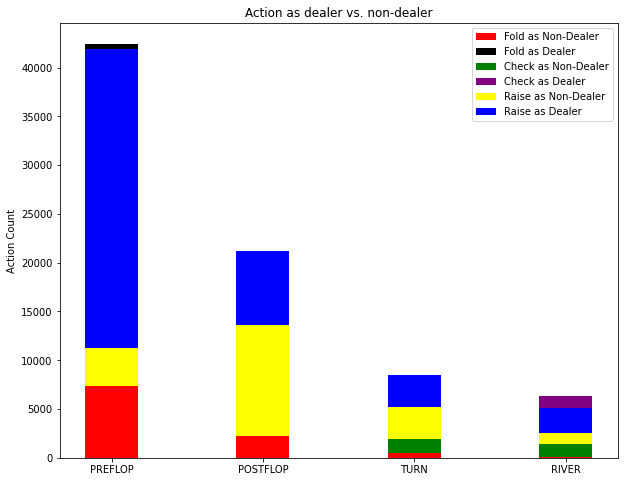

In [6]:
## Build dealer vs. Non-dealer chart

labels = ['PREFLOP', 'POSTFLOP', 'TURN', 'RIVER']
pre = action[0]
post = action[1]
turn = action[2]
river = action[3]
nd_fold = [pre[0][0], post[0][0], turn[0][0], river[0][0]]
d_fold = [pre[1][0], post[1][0], turn[1][0], river[1][0]]
nd_check = [pre[0][1], post[0][1], turn[0][1], river[0][1]]
d_check = [pre[1][1], post[1][1], turn[1][1], river[1][1]]
nd_raise = [pre[0][2], post[0][2], turn[0][2], river[0][2]]
d_raise = [pre[1][2], post[1][2], turn[1][2], river[1][2]]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

ax.bar(labels, nd_fold, width, color='red', label='Fold as Non-Dealer')
ax.bar(labels, d_fold, width, bottom=nd_fold, color='black',  label='Fold as Dealer')
ax.bar(labels, nd_check, width, bottom=d_fold, color='green',  label='Check as Non-Dealer')
ax.bar(labels, d_check, width, bottom=nd_check, color='purple', label='Check as Dealer')
ax.bar(labels, nd_raise, width, bottom=d_check, color='yellow', label='Raise as Non-Dealer')
ax.bar(labels, d_raise, width, bottom=nd_raise, color='blue', label='Raise as Dealer')

ax.set_ylabel('Action Count')
ax.set_title('Action as dealer vs. non-dealer')
ax.legend()

plt.show()


This shows the percentage of each action as the dealer and not as the dealer. Clearly the dealer is incentivised to push the action as they are the last to act in each betting round. This means that they can gain more information before making their decision and can therfore be more agressive. These ranges would look very different in a no limit holdem game but limit holdem incentivises longer hands, as you are never able to raise the pot to astronomical sizes and can therefore never lose your entire stack.

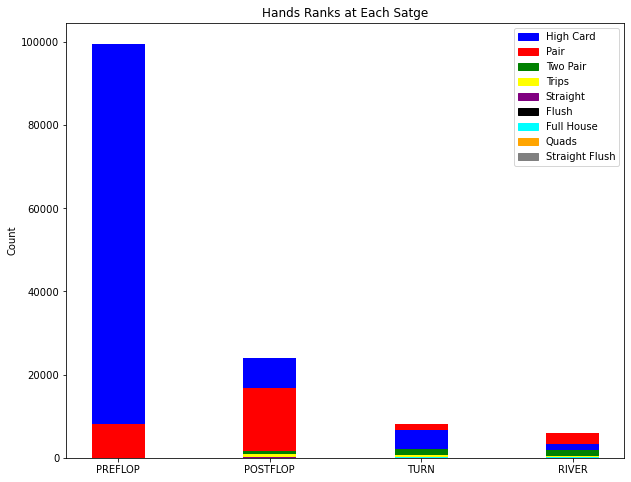

In [93]:
import matplotlib.pyplot as plt

## Build hand rank chart

labels = ['PREFLOP', 'POSTFLOP', 'TURN', 'RIVER']
pre = stage_hand_rank[0]
post = stage_hand_rank[1]
turn = stage_hand_rank[2]
river = stage_hand_rank[3]
high_card = [pre[0], post[0], turn[0], river[0]]
pair = [pre[1], post[1], turn[1], river[1]]
two_pair = [pre[2], post[2], turn[2], river[2]]
trips = [pre[3], post[3], turn[3], river[3]]
straight = [pre[4], post[4], turn[4], river[4]]
flush = [pre[5], post[5], turn[5], river[5]]
full_house = [pre[6], post[6], turn[6], river[6]]
quads = [pre[7], post[7], turn[7], river[7]]
straight_flush = [pre[8], post[8], turn[8], river[8]]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

colors = {'HIGH CARD': 'blue', 'PAIR':'red', 'TWO PAIR':'green',
             'TRIPS': 'yellow', 'STRAIGHT':'purple', 'FLUSH':'black',
             'FULL HOUSE': 'cyan', 'QUADS':'orange', 'STRAIGHT FLUSH':'gray'}    
colors_i = { 0: 'blue', 1:'red', 2:'green',
             3: 'yellow', 4:'purple', 5:'black',
             6: 'cyan', 7:'orange', 8:'gray'} 
labels = list(hand_ranks.keys())
plt.legend(handles, labels)

for stage, (hc, p, two_p, trip, s, f, fh, q, sf)  in enumerate(zip(high_card, pair, two_pair, trips, straight, flush, full_house, quads, straight_flush)):
    for i, (h, c) in enumerate(sorted([(hc, 0), (p, 1), (two_p, 2), (trip, 3), (s, 4), (f, 5), (fh, 6), (q, 7), (sf, 8)])):
        ax.bar(labels[stage], h, width, zorder=-i, color=colors_i[c])

plt.xticks(labels[0:4], ['PREFLOP', 'POSTFLOP', 'TURN', 'RIVER'])
ax.set_ylabel('Count')
ax.set_title('Hands Ranks at Each Satge')
plt.show()

This chart shows the hands that are being played by each opponent at each stage of the game. Most hands start as a high card except pocket pairs and they rapidly dwindle, as making good hands are rare. It is interesting to see that players play with drawing cards (ie. high card) with a hope to improve, but will not play those at the river, as they no longer have any chance to improve. 

# Approach and Methodology

In order to create data that could be input into a dataframe, an immense amount of preprocessing was needed. Iterating over each line and creating Hand objects. Hand objects had players which had various player statistics as well as a list of actions. A Hand object was then used to create a list of Decisions. Decisions take in various traits like the hole cards of the player, the communal cards, the actual decision made, and other hand statistics. These traits are then used to calculate the various features and written to a csv that can be loaded as a decision dataframe.

After this, most of the feature normalization is very simple, as most are either discrete values or simple numerical values.
* Note: I would like to hear ideas on any feature normalization I have overlooked or feature extraction ideas before moving on to train more models.

### Models

I trained one model as I have had to spend so much time extracting the features and the performance was decent, especially in a game that is inherently random. The results can be seen below. I used recursive feature elimination and cross-validated selection to train a random forest classifier.

* Note: We discussed using Random Forests and SVM but if there are other models you would reccommend after seeing the final data I would like to hear it.

### Challenges/Changes

I originally wanted to do no limit hold'em instead of limit hold'em and I wanted to use multiple players at the table. Both of those things became quickly intractable, as the dataset I had did not show hole cards unless they were shown down, making it impossible to extract the features I wanted for each decision. Limit hold'em also has only 3 actions fold, check, raise, whereas no limit holdem allows for raises of any size, making the state space exceptionally large.

In [94]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing


target_binarized = preprocessing.label_binarize(target_scaled, classes=[0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(features, target_binarized, random_state=3000) 

clf_featr_sele = RandomForestClassifier(n_estimators=30, 
                                        random_state=42,
                                        class_weight="balanced") 

rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')

clf = RandomForestClassifier(n_estimators=10, 
                             random_state=42,
                             class_weight="balanced") 
CV_rfc = GridSearchCV(clf, 
                      param_grid={'max_depth':[2,3]},
                      cv= 5, scoring = 'roc_auc')

pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',CV_rfc)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_sele',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        n_estimators=30,
                                                        random_state=42),
                       scoring='roc_auc')),
                ('clf_cv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=10,
                                                               random_state=42),
                              param_grid={'max_depth': [2, 3]},
                              scoring='roc_auc'))])

In [95]:
import matplotlib.pyplot as plt  
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt

accuracy = pipeline.score(X_test, y_test)
error = 1-accuracy
print("Accuracy=",accuracy)
print("Error=",error)

predictions = pipeline.predict(X_test)
print()
print(classification_report(y_test, predictions, target_names=['fold', 'check', 'raise']))
print()
print("AUC: %f"%metrics.roc_auc_score(y_test, predictions))

# print(pipeline.get_params()['steps'][1][1].estimator)
y_true = y_test
y_probas = pipeline.predict_proba(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas)
# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()
# metrics.plot_roc_curve(pipeline.get_params()['steps'][1][1].estimator, X_test, y_test) 
# plt.show()

Accuracy= 0.7816910467652317
Error= 0.2183089532347683



/Users/zacharydawson/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

        fold       0.55      0.74      0.63     13664
       check       0.55      0.50      0.52     12674
       raise       0.89      0.06      0.12     19126

   micro avg       0.57      0.39      0.46     45464
   macro avg       0.67      0.43      0.42     45464
weighted avg       0.69      0.39      0.39     45464
 samples avg       0.39      0.39      0.39     45464


AUC: 0.647006


# Remaining Work

Training and evaluating additional models is pretty much all that is left. I will likely train and tune random forest, naive bayes, and SVM. If I cannot improve the model to a reasonable level I may try to create some more data from other hand histories if the models are undertrained.